In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm

### Data Loader Class

Load's the data from the processed frames upto a defined sequence length

In [2]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length, transform=None):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}  # To store class ID to name mapping

        # Traverse through action categories and their subfolders
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            if not os.path.isdir(category_path):
                continue
            self.class_mapping[label] = category  # Map class ID to category name
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path):
                    frames = sorted(os.listdir(subfolder_path))  # Ensure frames are ordered

                    # Check if there are enough frames
                    if len(frames) >= sequence_length:
                        self.data.append((subfolder_path, frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        # Select frames sequentially from the start, up to sequence_length
        selected_frames = frames[:self.sequence_length]

        sequence = []
        for frame_file in selected_frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                # Try to open the image
                img = Image.open(frame_path).convert("L")  # Convert to grayscale
                if self.transform:
                    img = self.transform(img)

                # Flatten the image to a 1D tensor
                img = img.view(-1)  # Flattening the image to size 4096 (64x64)
                sequence.append(img)

            except (IOError, OSError) as e:
                # Log the error and skip the corrupted frame
                print(f"Warning: Skipping corrupted image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))  # Skip to the next sample

        # Stack frames into a tensor of shape [sequence_length, 4096]
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


### Augmentations

In [3]:
# Define augmentations and transformations
transform = transforms.Compose([
    # Spatial augmentations
    # RandomHorizontalFlip(p=0.5),                # Flip frames horizontally with 50% probability
    # RandomRotation(degrees=15),                # Random rotation within ±15 degrees
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),  # Random crop to 64x64, pad if needed

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),  # Adjust brightness/contrast
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Random blur
    
    # Conversion and normalization
    transforms.ToTensor(),                                # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])           # Normalize to [-1, 1]
])

### Paths and Hyperparameters for dataset

In [4]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 45
batch_size = 32
train_ratio = 0.8  # 80% for training, 20% for validation


### Loading and splitting the dataset

In [5]:
# Load the full dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 599
Train set size: 479
Validation set size: 120


### Visualizing dataset

In [6]:
def visualize_sequences(dataset, category_label, num_sequences=3, sequence_length=15):
    """
    Visualizes the first `num_sequences` sequences for a specific category label.
    
    Args:
        dataset: Instance of KTHProcessedDataset.
        category_label: Label of the category to visualize.
        num_sequences: Number of sequences to visualize.
        sequence_length: Length of each sequence.
    """
    sequences_shown = 0
    
    plt.figure(figsize=(15, num_sequences * 3))
    for i in range(len(dataset)):
        sequence, label = dataset[i]
        if label == category_label:
            for frame_idx in range(sequence_length):
                plt.subplot(num_sequences, sequence_length, sequences_shown * sequence_length + frame_idx + 1)
                frame = sequence[frame_idx].view(64, 64).cpu().numpy()  # Reshape to image dimensions
                plt.imshow(frame, cmap="gray")
                plt.axis("off")
            
            sequences_shown += 1
            if sequences_shown >= num_sequences:
                break

    plt.suptitle(f"Sequences for category label: {category_label}", fontsize=16)
    plt.show()

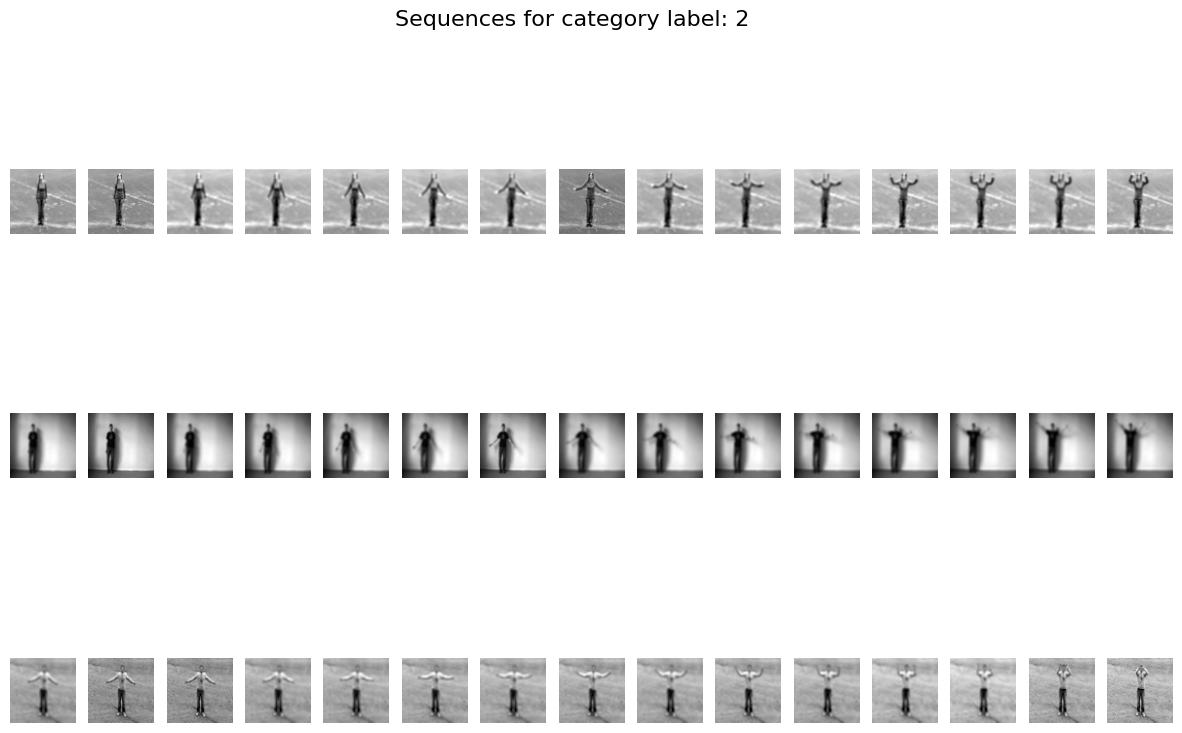

In [7]:
# Visualize sequences for category label 0 (e.g., walking)
visualize_sequences(dataset, category_label=2, num_sequences=3, sequence_length=15)

In [8]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


In [9]:
### This works
class LSTMCell(nn.Module):
    """
    Custom LSTM Cell implementation from scratch
    
    Args:
    - input_size: Number of input features
    - hidden_size: Number of hidden units
    - bias: Whether to use bias terms (default: True)
    """
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Combine all gates' weights into a single matrix for efficiency
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        
        # Bias terms
        if bias:
            self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
            self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        
        # Initialize weights
        self.reset_parameters()
    
    def reset_parameters(self):
        """
        Xavier uniform initialization for weights
        """
        std = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            nn.init.uniform_(weight, -std, std)
    
    def forward(self, x, hidden_state=None):
        """
        Forward pass for LSTM Cell
        
        Args:
        - x: input tensor of shape (batch_size, input_size)
        - hidden_state: tuple of (h, c) - previous hidden and cell states
        
        Returns:
        - new_h: new hidden state
        - new_c: new cell state
        """
        # Initialize hidden state if not provided
        if hidden_state is None:
            batch_size = x.size(0)
            h = x.new_zeros(batch_size, self.hidden_size)
            c = x.new_zeros(batch_size, self.hidden_size)
        else:
            h, c = hidden_state
        
        # Compute gate inputs
        gates = F.linear(x, self.weight_ih, self.bias_ih) + \
                F.linear(h, self.weight_hh, self.bias_hh)
        
        # Split gates
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        # Apply activation functions
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        
        # Update cell state
        new_c = (forgetgate * c) + (ingate * cellgate)
        
        # Compute new hidden state
        new_h = outgate * torch.tanh(new_c)
        
        return new_h, new_c

class LSTM(nn.Module):
    """
    Full LSTM implementation using LSTMCell
    
    Args:
    - input_size: Number of input features
    - hidden_size: Number of hidden units
    - num_layers: Number of LSTM layers
    - num_classes: Number of output classes
    - batch_first: Whether input is batch first (default: True)
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes, batch_first=True):
        print("here it is")
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList([
            LSTMCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
        # Classification layer
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass for multi-layer LSTM
        
        Args:
        - x: input tensor of shape (batch_size, sequence_length, input_size)
        
        Returns:
        - output: classification logits
        """
        # Ensure input is batch first
        if not self.batch_first:
            x = x.transpose(0, 1)
        
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states for all layers
        h_list = [torch.zeros(batch_size, self.hidden_size, device=x.device) 
                  for _ in range(self.num_layers)]
        c_list = [torch.zeros(batch_size, self.hidden_size, device=x.device) 
                  for _ in range(self.num_layers)]
        
        # Process each time step
        for t in range(seq_len):
            # Current input at time step t
            input_t = x[:, t, :]
            
            # Process through each layer
            for layer in range(self.num_layers):
                # Get LSTM cell for this layer
                cell = self.lstm_cells[layer]
                
                # Use previous layer's hidden state as input (or input_t for first layer)
                h_prev = input_t if layer == 0 else h_list[layer-1]
                
                # Update hidden and cell states
                h_list[layer], c_list[layer] = cell(h_prev, (h_list[layer], c_list[layer]))
        
        # Use the last hidden state for classification
        output = self.classifier(h_list[-1])
        
        return output


In [10]:
# # Training and Evaluation Utilities
# def train_video_classification_model(model, train_loader, criterion, optimizer, device):
#     """
#     Training function for video classification
    
#     Args:
#     - model: Video classification model
#     - train_loader: DataLoader for training data
#     - criterion: Loss function
#     - optimizer: Optimization algorithm
#     - device: Computing device (CPU/GPU)
    
#     Returns:
#     - Average training loss
#     """
#     model.train()
#     total_loss = 0
    
#     for sequences, labels in train_loader:
#         # Move data to device
#         sequences = sequences.to(device)
#         labels = labels.to(device)
        
#         # Zero gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(sequences)
        
#         # Compute loss
#         loss = criterion(outputs, labels)
        
#         # Backward pass
#         loss.backward()
        
#         # Update weights
#         optimizer.step()
        
#         # Track loss
#         total_loss += loss.item()
    
#     return total_loss / len(train_loader)

# def evaluate_video_classification_model(model, test_loader, criterion, device):
#     """
#     Evaluation function for video classification
    
#     Args:
#     - model: Video classification model
#     - test_loader: DataLoader for test data
#     - criterion: Loss function
#     - device: Computing device (CPU/GPU)
    
#     Returns:
#     - Average test loss
#     - Accuracy
#     """
#     model.eval()
#     total_loss = 0
#     correct_predictions = 0
#     total_predictions = 0
    
#     with torch.no_grad():
#         for sequences, labels in test_loader:
#             # Move data to device
#             sequences = sequences.to(device)
#             labels = labels.to(device)
            
#             # Forward pass
#             outputs = model(sequences)
            
#             # Compute loss
#             loss = criterion(outputs, labels)
#             total_loss += loss.item()
            
#             # Compute accuracy
#             _, predicted = torch.max(outputs.data, 1)
#             total_predictions += labels.size(0)
#             correct_predictions += (predicted == labels).sum().item()
    
#     return (total_loss / len(test_loader), 
#             correct_predictions / total_predictions * 100)


In [11]:
# input_size = 4096  # Flattened image size from dataset
# hidden_size = 256
# num_layers = 2
# num_classes = 6  # Typical number of action classes in KTH dataset
# batch_size = 32
# learning_rate = 0.001
# num_epochs = 50

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# # Initialize model
# model = LSTM(
#     input_size=input_size, 
#     hidden_size=hidden_size, 
#     num_layers=num_layers, 
#     num_classes=num_classes
# ).to(device)

In [13]:
# model

In [14]:
# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [15]:
# # Training loop
# for epoch in range(num_epochs):
#     train_loss = train_video_classification_model(
#         model, train_loader, criterion, optimizer, device
#     )
    
#     test_loss, accuracy = evaluate_video_classification_model(
#         model, val_loader, criterion, device
#     )
#     # Step the learning rate scheduler
#     scheduler.step()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], '
#           f'Train Loss: {train_loss:.4f}, '
#           f'Test Loss: {test_loss:.4f}, '
#           f'Accuracy: {accuracy:.2f}%')

### LSTM Implementation

In [16]:
# class LSTMCell(nn.Module):
#     def __init__(self, input_size, hidden_size, bias=True):
#         super(LSTMCell, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
        
#         # Weights for input gate
#         self.Wi = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
#         # Weights for forget gate
#         self.Wf = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
#         # Weights for cell state
#         self.Wc = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
#         # Weights for output gate
#         self.Wo = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        
#         # Biases
#         if bias:
#             self.bi = nn.Parameter(torch.Tensor(hidden_size))
#             self.bf = nn.Parameter(torch.Tensor(hidden_size))
#             self.bc = nn.Parameter(torch.Tensor(hidden_size))
#             self.bo = nn.Parameter(torch.Tensor(hidden_size))
#         else:
#             self.register_parameter('bi', None)
#             self.register_parameter('bf', None)
#             self.register_parameter('bc', None)
#             self.register_parameter('bo', None)
        
#         self.reset_parameters()
    
#     def reset_parameters(self):
#         # Xavier/Glorot initialization
#         std = 1.0 / np.sqrt(self.hidden_size)
#         for p in self.parameters():
#             p.data.uniform_(-std, std)
    
#     def forward(self, x, state):
#         # Unpack previous hidden and cell states
#         h_prev, c_prev = state
        
#         # Concatenate input and previous hidden state
#         combined = torch.cat((x, h_prev), dim=1)
        
#         # Input gate
#         i = torch.sigmoid(F.linear(combined, self.Wi, self.bi))
        
#         # Forget gate
#         f = torch.sigmoid(F.linear(combined, self.Wf, self.bf))
        
#         # Cell state candidate
#         c_candidate = torch.tanh(F.linear(combined, self.Wc, self.bc))
        
#         # Output gate
#         o = torch.sigmoid(F.linear(combined, self.Wo, self.bo))
        
#         # Update cell state
#         c_next = f * c_prev + i * c_candidate
        
#         # Update hidden state
#         h_next = o * torch.tanh(c_next)
        
#         return h_next, c_next

# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=1, output_size=6, bias=True):
#         super(LSTM, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.output_size = output_size
        
#         # Create LSTM cells for each layer
#         self.lstm_cells = nn.ModuleList([
#             LSTMCell(input_size if layer == 0 else hidden_size, 
#                      hidden_size, bias) 
#             for layer in range(num_layers)
#         ])
        
#         # Final fully connected layer for classification
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x, states=None):
#         # x shape: (batch_size, seq_len, input_size)
#         batch_size, seq_len, _ = x.size()
        
#         # Initialize hidden states if not provided
#         if states is None:
#             h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
#             c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
#             states = (h0, c0)
        
#         # Unpack initial states
#         h_prev, c_prev = states
        
#         # Output tensor to store hidden states for each timestep
#         outputs = []
        
#         # Process each timestep
#         for t in range(seq_len):
#             layer_input = x[:, t, :]
            
#             # Process through each LSTM layer
#             layer_h_states = []
#             for layer in range(self.num_layers):
#                 # Get cell state for this layer
#                 h_prev_layer = h_prev[layer]
#                 c_prev_layer = c_prev[layer]
                
#                 # Update hidden and cell states
#                 h_next, c_next = self.lstm_cells[layer](layer_input, (h_prev_layer, c_prev_layer))
                
#                 # Update layer input for next layer
#                 layer_input = h_next
                
#                 # Store updated states
#                 layer_h_states.append(h_next)
#                 h_prev[layer] = h_next
#                 c_prev[layer] = c_next
            
#             # Store final layer's hidden state
#             outputs.append(layer_h_states[-1])
        
#         # Stack outputs and pass through the final fully connected layer for classification
#         outputs = torch.stack(outputs, dim=1)
#         final_output = self.fc(outputs[:, -1, :])  # Use last hidden state for classification
        
#         return final_output

In [17]:
# input_size = 64*64  # For example, a flattened 8x8 frame
# hidden_size = 128
# num_layers = 2
# output_size = 6

# model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

# # Print the model structure
# print(model)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train the LSTM model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Get outputs for the full sequence
        
        # Only use the last time step's output for classification
        loss = criterion(outputs, labels)  # Use the last timestep output
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy for the last time step
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the LSTM model"""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get outputs for the full sequence
            
            loss = criterion(outputs, labels)  # Use the last timestep output
            running_loss += loss.item()

            # Compute accuracy for the last time step
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5):
    """Train and evaluate the LSTM model for a given number of epochs"""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        # Record the metrics
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        
        # Step the learning rate scheduler
        scheduler.step()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies

In [20]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CustomLSTMCell(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(CustomLSTMCell, self).__init__()
        
#         # Input weights and biases for each gate (input, forget, cell, output)
#         self.W_i = nn.Linear(input_size, hidden_size)
#         self.W_f = nn.Linear(input_size, hidden_size)
#         self.W_g = nn.Linear(input_size, hidden_size)
#         self.W_o = nn.Linear(input_size, hidden_size)

#         self.U_i = nn.Linear(hidden_size, hidden_size)
#         self.U_f = nn.Linear(hidden_size, hidden_size)
#         self.U_g = nn.Linear(hidden_size, hidden_size)
#         self.U_o = nn.Linear(hidden_size, hidden_size)

#         self.b_i = nn.Parameter(torch.zeros(hidden_size))
#         self.b_f = nn.Parameter(torch.zeros(hidden_size))
#         self.b_g = nn.Parameter(torch.zeros(hidden_size))
#         self.b_o = nn.Parameter(torch.zeros(hidden_size))
        
#     def forward(self, x_t, state_t):
#         h_prev, c_prev = state_t
        
#         # Calculate the gates
#         i_t = torch.sigmoid(self.W_i(x_t) + self.U_i(h_prev) + self.b_i)
#         f_t = torch.sigmoid(self.W_f(x_t) + self.U_f(h_prev) + self.b_f)
#         g_t = torch.tanh(self.W_g(x_t) + self.U_g(h_prev) + self.b_g)
#         o_t = torch.sigmoid(self.W_o(x_t) + self.U_o(h_prev) + self.b_o)
        
#         # Update cell state and hidden state
#         c_t = f_t * c_prev + i_t * g_t
#         h_t = o_t * torch.tanh(c_t)
        
#         return h_t, c_t

# class CustomLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers):
#         super(CustomLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
        
#         # Create custom LSTM cells for each layer
#         self.lstm_cells = nn.ModuleList([
#             CustomLSTMCell(input_size if i == 0 else hidden_size, hidden_size) 
#             for i in range(num_layers)
#         ])
        
#         # Output layer
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         batch_size, seq_len, _ = x.size()
        
#         # Initialize hidden and cell states for each layer
#         h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
#         c_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
#         # To store the output at each time step
#         outputs = []
        
#         for t in range(seq_len):
#             # Extract the time step t input
#             x_t = x[:, t, :]
            
#             # Pass through each layer
#             for layer in range(self.num_layers):
#                 h_t[layer], c_t[layer] = self.lstm_cells[layer](
#                     x_t, (h_t[layer], c_t[layer])
#                 )
#                 # The input to the next layer is the output of the current layer
#                 x_t = h_t[layer]
            
#             # Pass the final layer's output through the fully connected layer
#             output_t = self.fc(h_t[-1])
#             outputs.append(output_t)
        
#         # Stack the outputs to form the final output tensor
#         outputs = torch.stack(outputs, dim=1)
#         return outputs

# # Example usage
# input_size = 64*64  # Dimensionality of input features
# hidden_size = 20  # Number of hidden units
# output_size = 6  # Dimensionality of output features
# seq_len = 7  # Length of the input sequence
# batch_size = 3  # Batch size
# num_layers = 4  # Number of LSTM layers

# model = CustomLSTM(input_size, hidden_size, output_size, num_layers)

# # Random input tensor
# x = torch.randn(batch_size, seq_len, input_size)

# # Forward pass
# output = model(x)
# print("Output shape:", output.shape) 

In [21]:
# model = LSTM(
#     input_size=input_size, 
#     hidden_size=hidden_size, 
#     num_layers=num_layers, 
#     num_classes=num_classes
# ).to(device)

# # Define loss function and optimizer
# # criterion = nn.CrossEntropyLoss()
# # optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Learning rate scheduler
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# print(model)

#### without wandb

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the LSTM model
input_size = 64*64  # Vocabulary size or number of features (e.g., number of unique frames or actions)
hidden_size = 128  # Hidden size of the LSTM
num_classes = 6  # Number of output classes (for classification)
num_layers = 2
model = LSTM(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    num_classes=num_classes
).to(device)
# Loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
num_epochs = 25
learning_rate = 0.001
step_size = 5
gamma = 0.5

# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies = run_training(
    model, train_loader, val_loader, criterion, device,
    num_epochs, learning_rate, step_size, gamma
)

here it is


  4%|██▏                                                     | 1/25 [00:10<04:14, 10.60s/it]

Epoch 1/25
Train Loss: 1.7058, Train Accuracy: 0.2589
Eval Loss: 1.5792, Eval Accuracy: 0.2750


  8%|████▍                                                   | 2/25 [00:21<04:06, 10.72s/it]

Epoch 2/25
Train Loss: 1.4393, Train Accuracy: 0.3424
Eval Loss: 1.5285, Eval Accuracy: 0.3000


 12%|██████▋                                                 | 3/25 [00:32<03:55, 10.70s/it]

Epoch 3/25
Train Loss: 1.3681, Train Accuracy: 0.4092
Eval Loss: 1.3574, Eval Accuracy: 0.3333


 16%|████████▉                                               | 4/25 [00:42<03:44, 10.71s/it]

Epoch 4/25
Train Loss: 1.1659, Train Accuracy: 0.4885
Eval Loss: 1.2946, Eval Accuracy: 0.3917


 20%|███████████▏                                            | 5/25 [00:54<03:40, 11.04s/it]

Epoch 5/25
Train Loss: 1.1173, Train Accuracy: 0.5031
Eval Loss: 1.3303, Eval Accuracy: 0.3333


 24%|█████████████▍                                          | 6/25 [01:05<03:27, 10.92s/it]

Epoch 6/25
Train Loss: 1.0146, Train Accuracy: 0.5449
Eval Loss: 1.3576, Eval Accuracy: 0.3917


 28%|███████████████▋                                        | 7/25 [01:15<03:15, 10.84s/it]

Epoch 7/25
Train Loss: 0.9763, Train Accuracy: 0.5908
Eval Loss: 1.2399, Eval Accuracy: 0.4250


 32%|█████████████████▉                                      | 8/25 [01:26<03:03, 10.81s/it]

Epoch 8/25
Train Loss: 0.8975, Train Accuracy: 0.6284
Eval Loss: 1.2722, Eval Accuracy: 0.3833


 36%|████████████████████▏                                   | 9/25 [01:37<02:52, 10.75s/it]

Epoch 9/25
Train Loss: 0.8291, Train Accuracy: 0.6388
Eval Loss: 1.2789, Eval Accuracy: 0.4750


 40%|██████████████████████                                 | 10/25 [01:47<02:40, 10.70s/it]

Epoch 10/25
Train Loss: 0.7817, Train Accuracy: 0.6493
Eval Loss: 1.2302, Eval Accuracy: 0.3917


 44%|████████████████████████▏                              | 11/25 [01:58<02:29, 10.69s/it]

Epoch 11/25
Train Loss: 0.7076, Train Accuracy: 0.6910
Eval Loss: 1.2166, Eval Accuracy: 0.4917


 48%|██████████████████████████▍                            | 12/25 [02:09<02:19, 10.72s/it]

Epoch 12/25
Train Loss: 0.6746, Train Accuracy: 0.6994
Eval Loss: 1.2514, Eval Accuracy: 0.4083


 52%|████████████████████████████▌                          | 13/25 [02:19<02:08, 10.67s/it]

Epoch 13/25
Train Loss: 0.7113, Train Accuracy: 0.7182
Eval Loss: 1.3661, Eval Accuracy: 0.4000


 56%|██████████████████████████████▊                        | 14/25 [02:30<01:57, 10.73s/it]

Epoch 14/25
Train Loss: 0.7374, Train Accuracy: 0.7349
Eval Loss: 1.1732, Eval Accuracy: 0.4750


 60%|█████████████████████████████████                      | 15/25 [02:46<02:04, 12.41s/it]

Epoch 15/25
Train Loss: 0.6099, Train Accuracy: 0.7495
Eval Loss: 1.2098, Eval Accuracy: 0.4917


 64%|███████████████████████████████████▏                   | 16/25 [02:57<01:47, 11.95s/it]

Epoch 16/25
Train Loss: 0.5534, Train Accuracy: 0.7683
Eval Loss: 1.1869, Eval Accuracy: 0.5083


 68%|█████████████████████████████████████▍                 | 17/25 [03:09<01:34, 11.78s/it]

Epoch 17/25
Train Loss: 0.5343, Train Accuracy: 0.7829
Eval Loss: 1.1799, Eval Accuracy: 0.5167


 72%|███████████████████████████████████████▌               | 18/25 [03:19<01:19, 11.42s/it]

Epoch 18/25
Train Loss: 0.5185, Train Accuracy: 0.7871
Eval Loss: 1.2089, Eval Accuracy: 0.5000


 76%|█████████████████████████████████████████▊             | 19/25 [03:30<01:07, 11.21s/it]

Epoch 19/25
Train Loss: 0.4912, Train Accuracy: 0.7912
Eval Loss: 1.2549, Eval Accuracy: 0.5000


 80%|████████████████████████████████████████████           | 20/25 [03:41<00:55, 11.07s/it]

Epoch 20/25
Train Loss: 0.4922, Train Accuracy: 0.7871
Eval Loss: 1.2432, Eval Accuracy: 0.4583


 84%|██████████████████████████████████████████████▏        | 21/25 [03:51<00:43, 10.94s/it]

Epoch 21/25
Train Loss: 0.4784, Train Accuracy: 0.8038
Eval Loss: 1.2327, Eval Accuracy: 0.4583


 88%|████████████████████████████████████████████████▍      | 22/25 [04:02<00:32, 10.88s/it]

Epoch 22/25
Train Loss: 0.4610, Train Accuracy: 0.8205
Eval Loss: 1.2124, Eval Accuracy: 0.4750


 92%|██████████████████████████████████████████████████▌    | 23/25 [04:13<00:21, 10.83s/it]

Epoch 23/25
Train Loss: 0.4531, Train Accuracy: 0.8351
Eval Loss: 1.2511, Eval Accuracy: 0.5083


 96%|████████████████████████████████████████████████████▊  | 24/25 [04:24<00:10, 10.85s/it]

Epoch 24/25
Train Loss: 0.4414, Train Accuracy: 0.8351
Eval Loss: 1.2472, Eval Accuracy: 0.4500


100%|███████████████████████████████████████████████████████| 25/25 [04:34<00:00, 11.00s/it]

Epoch 25/25
Train Loss: 0.4281, Train Accuracy: 0.8413
Eval Loss: 1.2381, Eval Accuracy: 0.4917


In [22]:
import wandb

In [24]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train the LSTM model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Get outputs for the full sequence
        
        # Only use the last time step's output for classification
        loss = criterion(outputs, labels)  # Use the last timestep output
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy for the last time step
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the LSTM model"""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get outputs for the full sequence
            
            loss = criterion(outputs, labels)  # Use the last timestep output
            running_loss += loss.item()

            # Compute accuracy for the last time step
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5, project_name='lstm_training'):
    """Train and evaluate the LSTM model for a given number of epochs with W&B logging"""
    # Initialize W&B logging
    wandb.init(project=project_name, config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "step_size": step_size,
        "gamma": gamma,
        "optimizer": "Adam",
    },
    )
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []
    learning_rates = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        # Get current learning rate
        current_lr = scheduler.get_last_lr()[0]

        # Record the metrics
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)
        learning_rates.append(current_lr)

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": current_lr
        })

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Step the learning rate scheduler
        scheduler.step()

    # Finish W&B run
    wandb.finish()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the LSTM model
input_size = 64*64  # Vocabulary size or number of features (e.g., number of unique frames or actions)
hidden_size = 128  # Hidden size of the LSTM
num_classes = 6  # Number of output classes (for classification)
num_layers = 2
model = LSTM(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    num_classes=num_classes
).to(device)
# Loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
num_epochs = 20
learning_rate = 0.001
step_size = 5
gamma = 0.5

# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, train_loader, val_loader, criterion, device,
    num_epochs, learning_rate, step_size, gamma
)

here it is


  2%|█▍                                                      | 1/40 [00:10<07:01, 10.82s/it]

Epoch 1/40
Train Loss: 1.6836, Train Accuracy: 0.2610
Eval Loss: 1.5190, Eval Accuracy: 0.3417
Learning Rate: 0.001000


  5%|██▊                                                     | 2/40 [00:21<06:49, 10.78s/it]

Epoch 2/40
Train Loss: 1.4136, Train Accuracy: 0.3507
Eval Loss: 1.3973, Eval Accuracy: 0.4000
Learning Rate: 0.001000


  8%|████▏                                                   | 3/40 [00:32<06:39, 10.81s/it]

Epoch 3/40
Train Loss: 1.2554, Train Accuracy: 0.4718
Eval Loss: 1.4503, Eval Accuracy: 0.4000
Learning Rate: 0.001000


 10%|█████▌                                                  | 4/40 [00:43<06:28, 10.78s/it]

Epoch 4/40
Train Loss: 1.2180, Train Accuracy: 0.4885
Eval Loss: 1.3353, Eval Accuracy: 0.3667
Learning Rate: 0.001000


 12%|███████                                                 | 5/40 [00:54<06:18, 10.82s/it]

Epoch 5/40
Train Loss: 1.1441, Train Accuracy: 0.5115
Eval Loss: 1.2721, Eval Accuracy: 0.4000
Learning Rate: 0.001000


 15%|████████▍                                               | 6/40 [01:04<06:08, 10.84s/it]

Epoch 6/40
Train Loss: 1.0298, Train Accuracy: 0.5511
Eval Loss: 1.1892, Eval Accuracy: 0.4250
Learning Rate: 0.000500


 18%|█████████▊                                              | 7/40 [01:15<05:56, 10.81s/it]

Epoch 7/40
Train Loss: 0.9694, Train Accuracy: 0.5804
Eval Loss: 1.2182, Eval Accuracy: 0.4250
Learning Rate: 0.000500


 20%|███████████▏                                            | 8/40 [01:26<05:46, 10.82s/it]

Epoch 8/40
Train Loss: 0.8728, Train Accuracy: 0.6451
Eval Loss: 1.1265, Eval Accuracy: 0.4417
Learning Rate: 0.000500


 22%|████████████▌                                           | 9/40 [01:37<05:33, 10.77s/it]

Epoch 9/40
Train Loss: 0.9358, Train Accuracy: 0.6534
Eval Loss: 1.1654, Eval Accuracy: 0.4333
Learning Rate: 0.000500


 25%|█████████████▊                                         | 10/40 [01:47<05:22, 10.73s/it]

Epoch 10/40
Train Loss: 0.9030, Train Accuracy: 0.6388
Eval Loss: 1.2987, Eval Accuracy: 0.4083
Learning Rate: 0.000500


 28%|███████████████▏                                       | 11/40 [01:58<05:11, 10.74s/it]

Epoch 11/40
Train Loss: 0.7698, Train Accuracy: 0.7015
Eval Loss: 1.1366, Eval Accuracy: 0.4250
Learning Rate: 0.000250


 30%|████████████████▌                                      | 12/40 [02:09<05:00, 10.73s/it]

Epoch 12/40
Train Loss: 0.7143, Train Accuracy: 0.7119
Eval Loss: 1.1971, Eval Accuracy: 0.4333
Learning Rate: 0.000250


 32%|█████████████████▉                                     | 13/40 [02:20<04:50, 10.74s/it]

Epoch 13/40
Train Loss: 0.6449, Train Accuracy: 0.7516
Eval Loss: 1.1380, Eval Accuracy: 0.4083
Learning Rate: 0.000250


 35%|███████████████████▎                                   | 14/40 [02:30<04:38, 10.71s/it]

Epoch 14/40
Train Loss: 0.6066, Train Accuracy: 0.7620
Eval Loss: 1.1726, Eval Accuracy: 0.4667
Learning Rate: 0.000250


 38%|████████████████████▋                                  | 15/40 [02:41<04:27, 10.68s/it]

Epoch 15/40
Train Loss: 0.6954, Train Accuracy: 0.7077
Eval Loss: 1.1765, Eval Accuracy: 0.4083
Learning Rate: 0.000250


 40%|██████████████████████                                 | 16/40 [02:52<04:16, 10.69s/it]

Epoch 16/40
Train Loss: 0.6315, Train Accuracy: 0.7432
Eval Loss: 1.1082, Eval Accuracy: 0.4667
Learning Rate: 0.000125


 42%|███████████████████████▍                               | 17/40 [03:02<04:05, 10.67s/it]

Epoch 17/40
Train Loss: 0.5708, Train Accuracy: 0.7808
Eval Loss: 1.1490, Eval Accuracy: 0.4583
Learning Rate: 0.000125


 45%|████████████████████████▊                              | 18/40 [03:13<03:55, 10.72s/it]

Epoch 18/40
Train Loss: 0.5453, Train Accuracy: 0.7891
Eval Loss: 1.0953, Eval Accuracy: 0.4583
Learning Rate: 0.000125


 48%|██████████████████████████▏                            | 19/40 [03:24<03:45, 10.72s/it]

Epoch 19/40
Train Loss: 0.5121, Train Accuracy: 0.8079
Eval Loss: 1.0906, Eval Accuracy: 0.4750
Learning Rate: 0.000125


 50%|███████████████████████████▌                           | 20/40 [03:34<03:34, 10.74s/it]

Epoch 20/40
Train Loss: 0.5370, Train Accuracy: 0.7912
Eval Loss: 1.0886, Eval Accuracy: 0.4917
Learning Rate: 0.000125


 52%|████████████████████████████▉                          | 21/40 [03:45<03:24, 10.76s/it]

Epoch 21/40
Train Loss: 0.4787, Train Accuracy: 0.8184
Eval Loss: 1.1010, Eval Accuracy: 0.4667
Learning Rate: 0.000063


 55%|██████████████████████████████▎                        | 22/40 [03:56<03:14, 10.79s/it]

Epoch 22/40
Train Loss: 0.4740, Train Accuracy: 0.8142
Eval Loss: 1.0639, Eval Accuracy: 0.5167
Learning Rate: 0.000063


 57%|███████████████████████████████▌                       | 23/40 [04:07<03:03, 10.81s/it]

Epoch 23/40
Train Loss: 0.4577, Train Accuracy: 0.8267
Eval Loss: 1.0853, Eval Accuracy: 0.4750
Learning Rate: 0.000063


 60%|█████████████████████████████████                      | 24/40 [04:18<02:51, 10.74s/it]

Epoch 24/40
Train Loss: 0.4498, Train Accuracy: 0.8455
Eval Loss: 1.0907, Eval Accuracy: 0.4833
Learning Rate: 0.000063


 62%|██████████████████████████████████▍                    | 25/40 [04:28<02:40, 10.72s/it]

Epoch 25/40
Train Loss: 0.4406, Train Accuracy: 0.8476
Eval Loss: 1.0274, Eval Accuracy: 0.4750
Learning Rate: 0.000063


 65%|███████████████████████████████████▊                   | 26/40 [04:39<02:29, 10.71s/it]

Epoch 26/40
Train Loss: 0.4409, Train Accuracy: 0.8518
Eval Loss: 1.0498, Eval Accuracy: 0.4833
Learning Rate: 0.000031


 68%|█████████████████████████████████████▏                 | 27/40 [04:50<02:19, 10.70s/it]

Epoch 27/40
Train Loss: 0.4287, Train Accuracy: 0.8413
Eval Loss: 1.0868, Eval Accuracy: 0.4500
Learning Rate: 0.000031


 70%|██████████████████████████████████████▌                | 28/40 [05:00<02:08, 10.71s/it]

Epoch 28/40
Train Loss: 0.4205, Train Accuracy: 0.8580
Eval Loss: 1.1231, Eval Accuracy: 0.4667
Learning Rate: 0.000031


 72%|███████████████████████████████████████▉               | 29/40 [05:11<01:57, 10.72s/it]

Epoch 29/40
Train Loss: 0.4192, Train Accuracy: 0.8601
Eval Loss: 1.1048, Eval Accuracy: 0.4833
Learning Rate: 0.000031


 75%|█████████████████████████████████████████▎             | 30/40 [05:22<01:46, 10.69s/it]

Epoch 30/40
Train Loss: 0.4081, Train Accuracy: 0.8768
Eval Loss: 1.1137, Eval Accuracy: 0.4667
Learning Rate: 0.000031


 78%|██████████████████████████████████████████▋            | 31/40 [05:33<01:36, 10.74s/it]

Epoch 31/40
Train Loss: 0.4066, Train Accuracy: 0.8706
Eval Loss: 1.1004, Eval Accuracy: 0.4500
Learning Rate: 0.000016


 80%|████████████████████████████████████████████           | 32/40 [05:43<01:25, 10.73s/it]

Epoch 32/40
Train Loss: 0.4039, Train Accuracy: 0.8810
Eval Loss: 1.1016, Eval Accuracy: 0.4500
Learning Rate: 0.000016


 82%|█████████████████████████████████████████████▍         | 33/40 [05:54<01:15, 10.75s/it]

Epoch 33/40
Train Loss: 0.4013, Train Accuracy: 0.8789
Eval Loss: 1.1066, Eval Accuracy: 0.4750
Learning Rate: 0.000016


 85%|██████████████████████████████████████████████▊        | 34/40 [06:05<01:04, 10.69s/it]

Epoch 34/40
Train Loss: 0.3933, Train Accuracy: 0.8831
Eval Loss: 1.1320, Eval Accuracy: 0.4500
Learning Rate: 0.000016


 88%|████████████████████████████████████████████████▏      | 35/40 [06:15<00:53, 10.70s/it]

Epoch 35/40
Train Loss: 0.3934, Train Accuracy: 0.8810
Eval Loss: 1.0942, Eval Accuracy: 0.4917
Learning Rate: 0.000016


 90%|█████████████████████████████████████████████████▌     | 36/40 [06:26<00:42, 10.73s/it]

Epoch 36/40
Train Loss: 0.3896, Train Accuracy: 0.8873
Eval Loss: 1.1368, Eval Accuracy: 0.4333
Learning Rate: 0.000008


 92%|██████████████████████████████████████████████████▉    | 37/40 [06:37<00:32, 10.74s/it]

Epoch 37/40
Train Loss: 0.3867, Train Accuracy: 0.8810
Eval Loss: 1.1241, Eval Accuracy: 0.4750
Learning Rate: 0.000008


 95%|████████████████████████████████████████████████████▎  | 38/40 [06:48<00:21, 10.78s/it]

Epoch 38/40
Train Loss: 0.3805, Train Accuracy: 0.8894
Eval Loss: 1.1183, Eval Accuracy: 0.4250
Learning Rate: 0.000008


 98%|█████████████████████████████████████████████████████▋ | 39/40 [06:58<00:10, 10.74s/it]

Epoch 39/40
Train Loss: 0.3786, Train Accuracy: 0.8935
Eval Loss: 1.1358, Eval Accuracy: 0.4333
Learning Rate: 0.000008


100%|███████████████████████████████████████████████████████| 40/40 [07:09<00:00, 10.74s/it]

Epoch 40/40
Train Loss: 0.3865, Train Accuracy: 0.8789
Eval Loss: 1.1144, Eval Accuracy: 0.4583
Learning Rate: 0.000008


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_accuracy,▁▃▃▂▃▄▄▅▅▄▄▅▄▆▄▆▆▆▆▇▆█▆▇▆▇▅▆▇▆▅▅▆▅▇▅▆▄▅▆
eval_loss,█▆▇▅▄▃▄▂▃▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▃▂▂▃▂
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▄▄▅▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇█▇█████████████
train_loss,█▇▆▆▅▄▄▄▄▄▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
eval_accuracy,0.45833
eval_loss,1.11443
learning_rate,1e-05
train_accuracy,0.87891


In [ ]:
# Function to evaluate model and compute predictions
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            # Reshape and move to device
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(sequences)
            preds = torch.argmax(outputs, dim=1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Use the function to get results
y_true, y_pred = evaluate_model(model, test_loader)

# Class label names
label_names = [name for _, name in sorted(KTHProcessedDataset.class_mapping.items())]

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="LSTM")

### ConvLSTM

In [30]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, 
                 kernel_size=3, bias=True):
        """
        ConvLSTM Cell Implementation
        
        Args:
            input_channels (int): Number of input channels
            hidden_channels (int): Number of hidden channels
            kernel_size (int, optional): Convolution kernel size. Defaults to 3.
            bias (bool, optional): Whether to use bias in convolutions. Defaults to True.
        """
        super(ConvLSTMCell, self).__init__()
        
        # Padding to maintain spatial dimensions
        padding = kernel_size // 2
        
        # Combine input, hidden state, and cell state convolutions
        self.input_conv = nn.Conv2d(input_channels + hidden_channels, 
                                    4 * hidden_channels, 
                                    kernel_size, 
                                    padding=padding, 
                                    bias=bias)
        
        self.hidden_channels = hidden_channels
        
    def forward(self, input_tensor, cur_state):
        """
        Forward pass for ConvLSTM Cell
        
        Args:
            input_tensor (torch.Tensor): Input tensor 
                Shape: [batch_size, input_channels, height, width]
            cur_state (tuple): Current state 
                Contains hidden state and cell state
                Each: [batch_size, hidden_channels, height, width]
        
        Returns:
            tuple: Next hidden state and cell state
        """
        h_cur, c_cur = cur_state
        
        # Concatenate input and current hidden state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        
        # Perform convolution
        combined_conv = self.input_conv(combined)
        
        # Split the convolved tensor into gates
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, 
                                             self.hidden_channels, 
                                             dim=1)
        
        # Apply activation functions to gates
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        g = torch.tanh(cc_g)     # Cell gate
        
        # Update cell state
        c_next = f * c_cur + i * g
        
        # Update hidden state
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next
    
    def init_hidden(self, batch_size, image_size):
        """
        Initialize hidden and cell states
        
        Args:
            batch_size (int): Batch size
            image_size (tuple): (height, width) of the input image
        
        Returns:
            tuple: Initialized hidden and cell states
        """
        height, width = image_size
        device = next(self.parameters()).device
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=device))

class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, 
                 kernel_size=3, num_layers=1, num_classes=6, 
                 bias=True):
        """
        ConvLSTM for Video Classification
        
        Args:
            input_channels (int): Number of input channels
            hidden_channels (int or list): Number of hidden channels per layer
            kernel_size (int, optional): Convolution kernel size. Defaults to 3.
            num_layers (int, optional): Number of ConvLSTM layers. Defaults to 1.
            num_classes (int, optional): Number of action classes. Defaults to 6.
            bias (bool, optional): Whether to use bias in convolutions. Defaults to True.
        """
        super(ConvLSTM, self).__init__()
        
        # Ensure hidden_channels is a list
        if not isinstance(hidden_channels, list):
            hidden_channels = [hidden_channels] * num_layers
        
        # Create ConvLSTM layers
        self.convlstm_layers = nn.ModuleList([
            ConvLSTMCell(
                input_channels if i == 0 else hidden_channels[i-1], 
                hidden_channels[i], 
                kernel_size, 
                bias
            ) for i in range(num_layers)
        ])
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),
            nn.Linear(hidden_channels[-1], num_classes)
        )
        
        self.num_layers = num_layers
    
    def forward(self, x):
        """
        Forward pass for ConvLSTM
        
        Args:
            x (torch.Tensor): Input video sequence 
               Shape: [batch_size, sequence_length, channels, height, width]
        
        Returns:
            torch.Tensor: Class predictions
        """
        # Normalize input tensor to [batch_size, sequence_length, channels, height, width]
        if len(x.size()) == 4:
            # [batch_size, sequence_length, height, width] - assume single channel
            x = x.unsqueeze(2)
        elif len(x.size()) == 5:
            # Handle [batch_size, sequence_length, height, width, channels]
            x = x.permute(0, 1, 4, 2, 3)
            
        # Ensure input is in the right shape
        batch_size, seq_len, channels, height, width = x.size()
        
        # Initialize hidden states for each layer
        hidden_states = [
            layer.init_hidden(batch_size, (height, width)) 
            for layer in self.convlstm_layers
        ]
        
        # Iterate through sequence
        for t in range(seq_len):
            # Input for current timestep
            x_t = x[:, t, :, :, :]
            
            # Propagate through ConvLSTM layers
            for layer_idx in range(self.num_layers):
                # Get current layer and its hidden state
                layer = self.convlstm_layers[layer_idx]
                h, c = hidden_states[layer_idx]
                
                # Update hidden state
                h_next, c_next = layer(x_t, (h, c))
                
                # Update for next iteration
                hidden_states[layer_idx] = (h_next, c_next)
                
                # For intermediate layers, use output as input
                x_t = h_next
        
        # Use final hidden state of last layer for classification
        output = self.classifier(h_next)
        
        return output

In [1]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define the LSTM model
# input_size = 64*64  # Vocabulary size or number of features (e.g., number of unique frames or actions)
# hidden_size = 128  # Hidden size of the LSTM
# num_classes = 6  # Number of output classes (for classification)
# num_layers = 2
# model = ConvLSTM(
#     input_channels=1, 
#     hidden_channels=[64, 128], 
#     num_layers=num_layers, 
#     num_classes=num_classes
# ).to(device)
# # Loss function
# criterion = nn.CrossEntropyLoss()

# # Hyperparameters
# num_epochs = 40
# learning_rate = 0.001
# step_size = 5
# gamma = 0.5

# # Run training
# model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
#     model, train_loader, val_loader, criterion, device,
#     num_epochs, learning_rate, step_size, gamma, 'convlstm_training'
# )